In [154]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt   
import seaborn as sns             

In [155]:
def map_to_macrocategory(category):
    if category in ['BEVERAGES', 'BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 
                    'GROCERY I', 'GROCERY II', 'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD']:
        return 'Alimentos e Bebidas'
    elif category in ['BABY CARE', 'BEAUTY', 'PERSONAL CARE']:
        return 'Cuidados Pessoais e Saúde'
    elif category in ['CLEANING', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 
                      'HOME CARE', 'LAWN AND GARDEN']:
        return 'Casa e Jardim'
    elif category in ['LADIESWEAR', 'LINGERIE']:
        return 'Moda e Vestuário'
    elif category == 'AUTOMOTIVE':
        return 'Automotivo'
    elif category == 'PET SUPPLIES':
        return 'Animais de Estimação'
    elif category in ['BOOKS', 'MAGAZINES', 'CELEBRATION', 'PLAYERS AND ELECTRONICS', 'HARDWARE']:
        return 'Lazer, Tecnologia e Ferramentas'
    elif category == 'LIQUOR,WINE,BEER':
        return 'Bebidas Alcoólicas'
    elif category == 'SCHOOL AND OFFICE SUPPLIES':
        return 'Escola e Escritório'
    else:
        return 'Outros'

In [156]:
def adding_date(data):
    data['date']= pd.to_datetime(data['date'])
    data.set_index('date', inplace = True)
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'date'}, inplace=True)
    return data


In [157]:
treino = pd.read_csv('Data/train.csv.gz', compression='gzip')
treino= treino.drop(columns=['id'])
treino['date']= pd.to_datetime(treino['date'])
stores = pd.read_csv('Data/stores.csv')
oil = pd.read_csv('Data/oil.csv')
holidays = pd.read_csv('Data/holidays_events.csv')

In [158]:
null_counts = oil.isnull().sum()
print(null_counts)

date           0
dcoilwtico    43
dtype: int64


In [159]:
oil = adding_date(oil)

In [160]:
oil.iloc[0] = oil.iloc[0].fillna(95)
oil =oil.ffill()

In [161]:
dados= pd.merge(treino, oil, on=['date'], how= 'left')

In [162]:
dados.describe

<bound method NDFrame.describe of               date  store_nbr                      family     sales  \
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  dcoilwtico  
0                  0       95.00  
1                  0       95.00  
2       

In [163]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
 5   dcoilwtico   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 137.4+ MB


In [164]:
dados["family"].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [165]:
null_counts = dados.isnull().sum()
print(null_counts)

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
dtype: int64


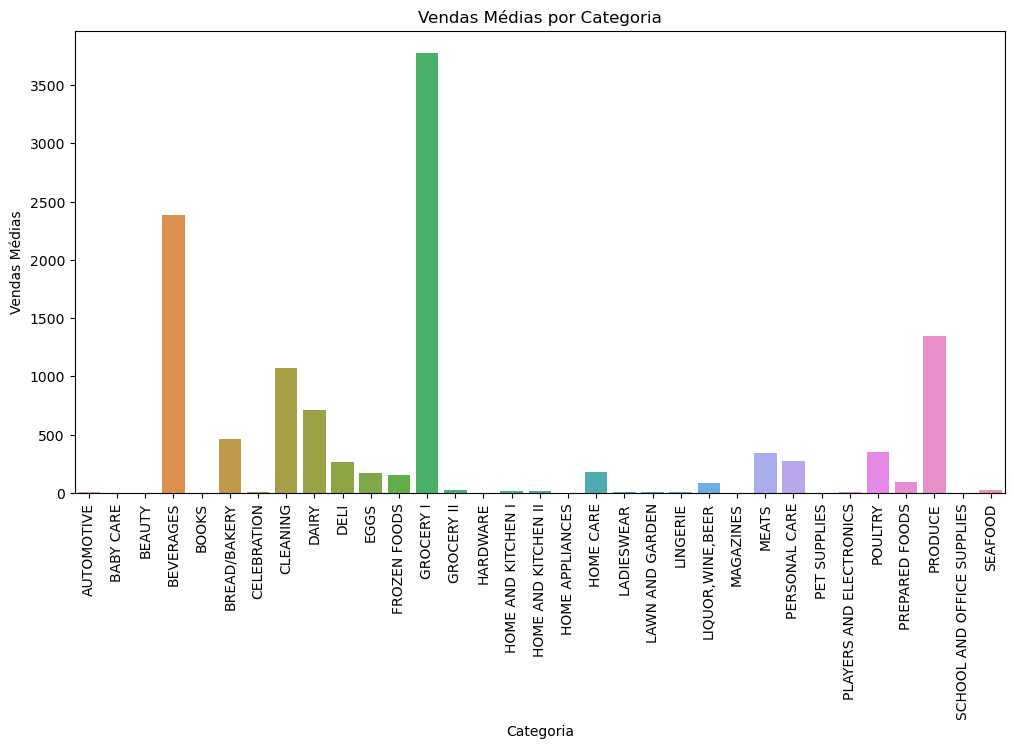

In [167]:
category_means = treino.groupby('family')['sales'].mean().reset_index()

# Plotando o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='family', y='sales', data=category_means)
plt.xticks(rotation=90)
plt.title('Vendas Médias por Categoria')
plt.xlabel('Categoria')
plt.ylabel('Vendas Médias')
plt.show()

In [168]:
dados['holiday'] = 0

In [170]:
holidays['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [171]:
"""holidays['date']= pd.to_datetime(holidays['date'])
holiday_dates_set = set(holidays['date'])

for index, row in dados.iterrows():
    data = row['date']
    if data in holiday_dates_set:
        # Busca eficiente por dados da loja, evitando erros com try-except
        try:
            store_data = stores[stores['store_nbr'] == row['store_nbr']].iloc[0]
            city = store_data['city']
            state = store_data['state']

            # Filtrar feriados para a data corrente para verificar condições adicionais
            filtered_holidays = holidays[holidays['date'] == data]
            for _, hol_row in filtered_holidays.iterrows():
                if not hol_row['transferred']:
                    if hol_row['locale'] == 'National':
                        dados.at[index, 'holiday'] = 1
                    elif hol_row['locale'] == 'Regional' and hol_row['locale_name'] == state:
                        dados.at[index, 'holiday'] = 1
                    elif hol_row['locale'] == 'Local' and hol_row['locale_name'] == city:
                        dados.at[index, 'holiday'] = 1
        except IndexError:
            print(f"No store data available for store number {row['store_nbr']} on {data}")"""

'holidays[\'date\']= pd.to_datetime(holidays[\'date\'])\nholiday_dates_set = set(holidays[\'date\'])\n\nfor index, row in dados.iterrows():\n    data = row[\'date\']\n    if data in holiday_dates_set:\n        # Busca eficiente por dados da loja, evitando erros com try-except\n        try:\n            store_data = stores[stores[\'store_nbr\'] == row[\'store_nbr\']].iloc[0]\n            city = store_data[\'city\']\n            state = store_data[\'state\']\n\n            # Filtrar feriados para a data corrente para verificar condições adicionais\n            filtered_holidays = holidays[holidays[\'date\'] == data]\n            for _, hol_row in filtered_holidays.iterrows():\n                if not hol_row[\'transferred\']:\n                    if hol_row[\'locale\'] == \'National\':\n                        dados.at[index, \'holiday\'] = 1\n                    elif hol_row[\'locale\'] == \'Regional\' and hol_row[\'locale_name\'] == state:\n                        dados.at[index, \'holi

In [172]:
# Adicionando coluna 'holiday' com 0 inicialmente
dados['holiday'] = 0
holidays['transferred'] = holidays['transferred'].astype(bool)
holidays['date']= pd.to_datetime(holidays['date'])
# Merge de 'dados' com 'stores' para trazer 'city' e 'state'
dados = dados.merge(stores[['store_nbr', 'city', 'state']], on='store_nbr', how='left')

# Selecionando apenas colunas relevantes de 'holidays' para o merge
holidays_relevant = holidays[['date', 'locale', 'locale_name', 'transferred']]

# Merge de 'dados' com 'holidays' alinhando por 'date' e considerando as colunas relevantes
dados = dados.merge(holidays_relevant, on='date', how='left', suffixes=('', '_hol'))
dados['transferred'] = dados['transferred'].fillna(False)
# Condições para definir 'holiday' com base em 'locale'
dados.loc[(dados['locale'] == 'National') & ~dados['transferred'], 'holiday'] = 1
dados.loc[(dados['locale'] == 'Regional') & (dados['locale_name'] == dados['state']) & ~dados['transferred'], 'holiday'] = 1
dados.loc[(dados['locale'] == 'Local') & (dados['locale_name'] == dados['city']) & ~dados['transferred'], 'holiday'] = 1

# Limpar colunas desnecessárias se necessário
dados.drop(columns=['city', 'state', 'locale', 'locale_name', 'transferred'], errors='ignore', inplace=True)

In [173]:
dados.dtypes

date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dcoilwtico            float64
holiday                 int64
dtype: object